In [1]:
# import packages
import os
import math

# normal packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# algo of KMeans in time series
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

# algo of KNN in time series
from pyts.classification import KNeighborsClassifier

# Hold-out validation  
from sklearn.model_selection import train_test_split

# elbow visualizer
from yellowbrick.cluster import kelbow_visualizer

# zscore transformation
from sklearn.preprocessing import StandardScaler

# result evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report


## Clustering

In [2]:
#Read the csv file
df = pd.read_csv('SyntheticControl.csv')

# remove the first column which is useless
df = df.iloc[:, 1:]

# present each time series as a column
TimeSeries = []
for i in range(len(df.T.columns)):
    TimeSeries.append(df.T[df.T.columns[i]])
    
# show the dataframe
df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,65.241107,87.146702,75.098625,74.887742,65.778916,84.434140,52.193746,61.400110,90.171927,58.820940,...,75.465646,48.950314,84.370530,50.843247,88.953278,89.169558,79.470492,82.954877,52.457060,54.024224
1,95.502049,92.905590,78.576828,71.442402,83.528752,85.856799,73.748110,99.012398,74.601750,81.651895,...,103.060587,79.248029,75.667277,99.376600,75.797590,90.732904,95.340596,103.969061,89.226341,88.543971
2,36.247435,37.722835,40.889600,35.140243,34.448231,37.505303,42.390089,41.781825,34.379877,41.277195,...,36.633747,36.803596,42.334351,36.529828,42.061866,38.257044,41.261728,40.486751,39.045635,38.983055
3,94.581808,95.928269,100.455981,110.185162,101.732643,93.962046,113.579234,105.662455,94.760914,82.960680,...,97.554189,82.290346,100.841850,109.428963,85.987056,87.191285,112.951571,85.331473,97.131444,88.694465
4,64.996050,63.301197,66.389831,46.481921,38.473900,49.501502,55.842843,66.804706,47.617717,35.630545,...,58.076316,60.277473,34.406360,37.772866,64.929207,45.908775,41.092693,47.580428,51.139456,57.067303


* zscore transformation by StandardScaler
* normalize each time series by their own values
* zscore scaling by spicy.stats only is to normalize the data by columns, not by rows

In [3]:

for i in range(len(TimeSeries)):
    TimeSeries[i] = pd.DataFrame(np.array(TimeSeries[i]).reshape(-1,1))
    TimeSeries[i] = StandardScaler().fit_transform(TimeSeries[i])
    TimeSeries[i]= TimeSeries[i].reshape(len(TimeSeries[i]))

In [4]:
# set it as an array is just convenient for the following computation
TimeSeries_zscore = np.array(TimeSeries)

a. What is “inertia” in the context of DTW?
- Inertia is the sum of distances of samples to their closest cluster center
- The distance is the minimum euclidean distance between the first point in the first series
  and every point in the second series calculated by dynamic programming


b. Why is it important to determine an appropriate number of clusters?
- An appropriate number of clusters can meaningfully group data. By grouping objects, similar objects can be classified into one class, and dissimilar objects can be classified into different classes.



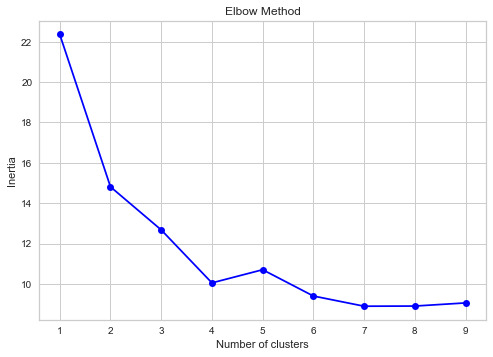

In [5]:
# elbow method
# iterate no. of clusters = 1 to 10 with DBA 
# appending the inertia as y axis
inertia_elbow = []
for i in range(1,10): 
    dba_kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter_barycenter=10)
    dba_kmeans.fit(TimeSeries_zscore)
    inertia_elbow.append(dba_kmeans.inertia_)

plt.plot(range(1, 10), inertia_elbow, marker='o', color='blue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show();
#-----------------------------------------------------------------------------------------------------------------------
# Use the quick method and immediately show the elbow figure
# model = TimeSeriesKMeans(metric="dtw", max_iter_barycenter=10)
# visualizer = kelbow_visualizer(model, TimeSeries_zscore, k=(1,10))
#-----------------------------------------------------------------------------------------------------------------------

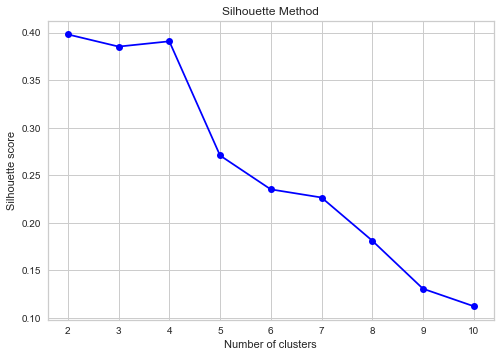

In [6]:
# Silhouette method
# iterate no. of clusters = 1 to 10 with DBA 
# appending the inertia as y axis
inertia_Silhouette = []
for i in range(2,10+1): 
    dba_kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter_barycenter=10)
    labels = dba_kmeans.fit(TimeSeries_zscore).labels_
    inertia_Silhouette.append(silhouette_score(TimeSeries_zscore, labels, metric="dtw"))

plt.plot(range(2, 10+1), inertia_Silhouette, marker='o', color='blue')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show();

#### 
What is the shape that you see? 
- The slope decreases dramatically when k <= 4, after k > 4 the slope drops steadily. 

How is this similar to what you saw in DSCI 5240 for determining a good number of clusters with non-time series data?
- They are almost identical in image, the only difference is the definition of the y-axis. 
- For non-time series data, the y-axis is the sum of squared error distance between the centroid and each observation
- For time series data with dba, the y-axis is the minimum euclidean distance between the first point in the first series and every point in the second series calculated by dynamic programming


### To sum up
- In view of all this, what do you think is the best number of clusters?
- Based on the combined result of elbow method and silhouette method as below, k = 4 is the optimal number

In [7]:
# perform the TimeSeriesKMeans and get the cluster lables after prediction
dba_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter_barycenter=10)
dba_labels = dba_km.fit_predict(TimeSeries_zscore)

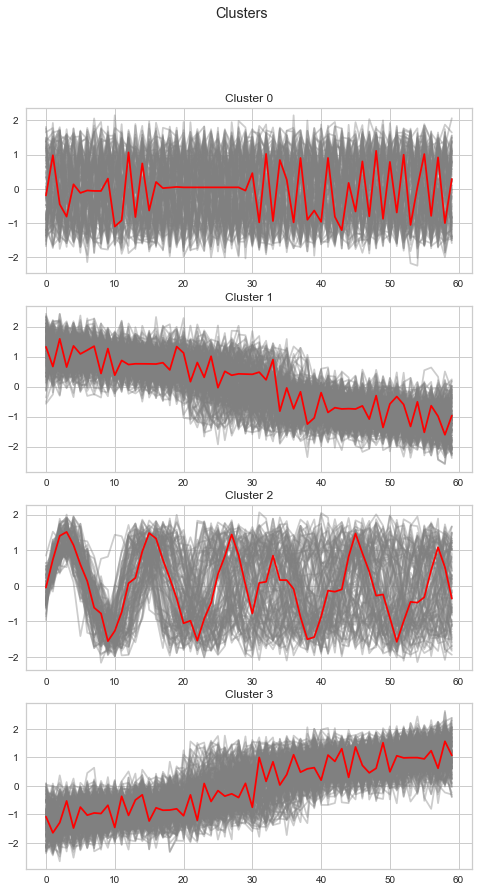

In [18]:
# plot the clusters and their average representation using dtw_barycenter_averaging to calculate the distance among the series
n_clusters = 4
plot_count = math.ceil(math.sqrt(n_clusters))

fig, axs = plt.subplots(4, 1,figsize=(8,14))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(dba_labels):
    cluster = []
    for i in range(len(dba_labels)):
            if(dba_labels[i]==label):
                axs[row_i].plot(TimeSeries_zscore[i],c="gray",alpha=0.4)
                cluster.append(TimeSeries_zscore[i])
    if len(cluster) > 0:
        axs[row_i].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i].set_title("Cluster "+str(int(row_i*plot_count/2)))
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

## k-Nearest Neighbors

In [9]:
# cluster labels ordered by df's index packed as dataframe df_lables
tickers = df.index
cluster_labels = [label for label in dba_labels]
df_lables = pd.DataFrame(zip(tickers,cluster_labels),columns=["Series","Tags"]).set_index("Series")

In [10]:
# merge two df using inner join
df_with_tags = pd.merge(df, df_lables, left_index=True, right_index=True)

# check if any unmatched cells after inner join
# 'False' means no unmatched cells
df_with_tags.isnull().values.any()

False

In [11]:
# seperate X and y dataset
X = df_with_tags.drop('Tags',axis=1)
y = df_with_tags['Tags']

In [12]:
# present each time series of X as a column
# normalize time series of X as above
TimeSeries_X = []
for i in range(len(X.T.columns)):
    TimeSeries_X.append(X.T[X.T.columns[i]])
    
for i in range(len(TimeSeries_X)):
    TimeSeries_X[i] = pd.DataFrame(np.array(TimeSeries_X[i]).reshape(-1,1))
    TimeSeries_X[i] = StandardScaler().fit_transform(TimeSeries_X[i])
    TimeSeries_X[i]= TimeSeries_X[i].reshape(len(TimeSeries_X[i]))

In [13]:
# set it as an array is just convenient for the following computation
TimeSeries_X_zscore = np.array(TimeSeries_X)

In [14]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(TimeSeries_X_zscore, y, test_size=0.3) # 70% training and 30% test

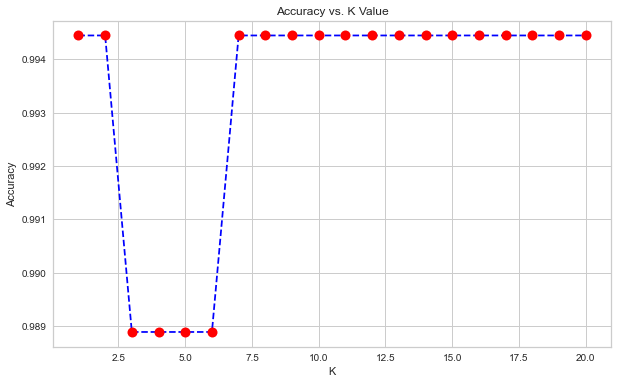

Maximum Accuracy: 0.9944444444444445 at K = 1


In [15]:
# stores the f1 score with weighted mean of eaach labels 
# take the range of k from 1 to 20
accuracy = []
for i in range(1,21):
    neigh = KNeighborsClassifier(n_neighbors = i, metric='dtw').fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    accuracy.append(accuracy_score(y_test, yhat))

# plot the error rate vs k graph 
plt.figure(figsize=(10,6))
plt.plot(range(1,21), accuracy, color = 'blue',linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show();
print("Maximum Accuracy:",max(accuracy),"at K =",accuracy.index(max(accuracy))+1)

In [17]:
# perform knn model with k = 1
knn_model = KNeighborsClassifier(n_neighbors = 1, metric='dtw').fit(X_train, y_train)

# get the classification report
y_pre = knn_model.predict(X_test)
print(classification_report(y_test, y_pre))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      1.00      1.00        55
           2       1.00      0.97      0.98        33
           3       1.00      1.00      1.00        59

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



'\nTherefore, k = 1 is the best value\n'

###  **Therefore, k = 1 is the best value**